## DS 105 - Machine Learning Project Proposal
Student name: Chow Hooi Koon

Project objective: Find out the best machine learning model which has the nearest prediction of the next day stock price. 

I will be using dataset from the open sources of yfinance (Yahoo Finance). 
I am going to predict the LVMH stock price (EPA: MC.PA). 
LVMH Moët Hennessy Louis Vuitton, commonly known as LVMH, is a French multinational corporation and conglomerate specializing in luxury goods, headquartered in Paris, France.

In [1]:
# import libraries

import yfinance as yf  # use this library to upload data from Yahoo APT
import pandas as pd
import numpy as np
import datetime
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline
plt.style.use('fivethirtyeight')

# Step 1: Data Collection, Cleaning and Preparation

In [2]:
# define the ticket
lvmh = yf.Ticker('MC.PA')
# display stock information
lvmh.info

{'zip': '75008',
 'sector': 'Consumer Cyclical',
 'fullTimeEmployees': 148343,
 'longBusinessSummary': "LVMH MoÃ«t Hennessy - Louis Vuitton, SociÃ©tÃ© EuropÃ©enne operates as a luxury products company. The company offers champagnes, wines, and spirits under the Ao Yun, Ardbeg, Belvedere, Bodega Numanthia, Cape Mentelle, Chandon, ChÃ¢teau Cheval Blanc, ChÃ¢teau d'Yquem, Cheval des Andes, Clos des Lambrays, Clos19, Cloudy Bay, Dom PÃ©rignon, Glenmorangie, Hennessy, Krug, Mercier, MoÃ«t & Chandon, Newton, Vineyard, Ruinart, Terrazas de los Andes, Veuve Clicquot, Volcan de mi Tierra, and Woodinville brands. It also provides fashion and leather products under the Berluti, Celine, Christian Dior, Emilio Pucci, Fendi, Givenchy, Kenzo, Loewe, Loro Piana, Louis Vuitton, Marc Jacobs, Moynat, Nicholas Kirkwood, Pink Shirtmaker, and Rimowa brands. In addition, the company offers perfumes and cosmetics under the Acqua di Parma, Benefit Cosmetics, Fenty Beauty by Rihanna, Fresh, Parfums Givenchy, Gu

In [3]:
# get the stock data
df = yf.download ("MC.PA", start="2017-01-02", end="2021-05-01")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,181.350006,182.000000,180.649994,181.800003,166.862595,287802
2017-01-03,182.100006,182.699997,179.449997,179.699997,164.935089,599351
2017-01-04,180.449997,180.500000,177.199997,178.100006,163.466599,635790
2017-01-05,177.350006,177.350006,175.800003,176.949997,162.411072,768148
2017-01-06,177.100006,179.550003,176.500000,179.250000,164.522095,551130
...,...,...,...,...,...,...
2021-04-26,623.900024,629.599976,622.000000,625.799988,625.799988,265587
2021-04-27,625.000000,633.900024,623.900024,632.700012,632.700012,320541
2021-04-28,632.700012,635.299988,628.599976,633.200012,633.200012,262268


In [4]:
#display data set information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1106 entries, 2017-01-02 to 2021-04-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1106 non-null   float64
 1   High       1106 non-null   float64
 2   Low        1106 non-null   float64
 3   Close      1106 non-null   float64
 4   Adj Close  1106 non-null   float64
 5   Volume     1106 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 60.5 KB


In [5]:
# check for null value
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# check for data set describtion 
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1.106000e+03
mean,329.486031,332.634991,326.197558,329.617947,317.607665,6.089943e+05
std,98.568382,99.699664,97.623894,98.902431,102.825180,3.027314e+05
min,177.100006,177.350006,175.800003,176.949997,162.411072,0.000000e+00
25%,247.262497,249.012501,245.162495,246.949997,231.010235,4.273985e+05
50%,307.050003,309.850006,304.125000,307.824997,292.584869,5.447280e+05
75%,391.075005,394.499992,386.637497,391.200012,383.610451,6.966282e+05
max,635.900024,639.900024,632.200012,635.700012,635.700012,3.098476e+06


<AxesSubplot:xlabel='Date'>

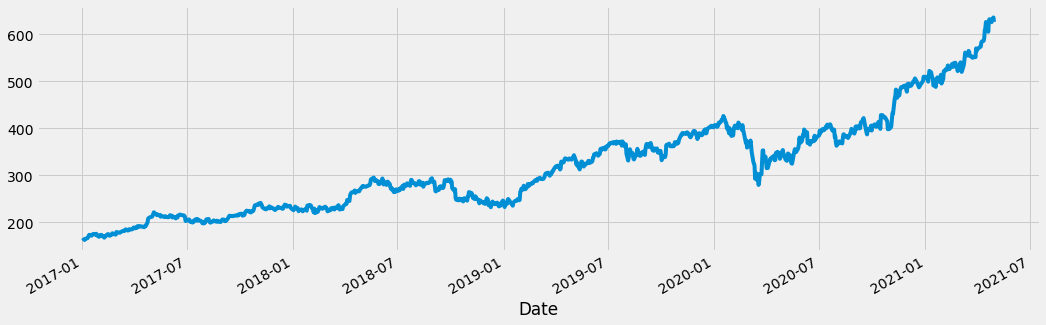

In [7]:
# Visualize the data set

df['Adj Close'].plot(figsize=(16,5))

# Step 2: Data Split

In [8]:
# get the Adjusted Close Price
df = df[['Adj Close']]
df.head()

,Adj Close
Date,
2017-01-02,166.862595
2017-01-03,164.935089
2017-01-04,163.466599
2017-01-05,162.411072
2017-01-06,164.522095


In [9]:
# A variable for predicting 'n' days out into the furure
forecast_out = 1
# Create another column the target or dependent variable shifted 'n' units up
df = pd.DataFrame({'Adj Close': df['Adj Close'],'Prediction': df['Adj Close'].shift(-forecast_out)})
df.tail()

,Adj Close,Prediction
Date,,
2021-04-26,625.799988,632.700012
2021-04-27,632.700012,633.200012
2021-04-28,633.200012,635.700012
2021-04-29,635.700012,626.200012
2021-04-30,626.200012,NaN


In [10]:
# create the independent data set (X)
# convert the dataframe to a numpy array
X = np.array(df.drop(['Prediction'],1))
# remove the last 'n' rows
X = X[:-forecast_out]
X

array([[166.8625946 ],
       [164.93508911],
       [163.46659851],
       ...,
       [632.70001221],
       [633.20001221],
       [635.70001221]])

In [11]:
# create the dependent data set (y)
# convert the dataframe to a numpy array
y = np.array(df['Prediction'])
# get all of the y values except the last 'n' rows
y = y[:-forecast_out]
y

array([164.93508911, 163.46659851, 162.41107178, ..., 633.20001221,
       635.70001221, 626.20001221])

In [12]:
# split the data into 80% training and 20% testing
x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# check if total observation makes sense
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(884, 1)
(221, 1)
(884,)
(221,)


# Step 3: Machine Learning Model building 
1) Support Vector Regressor \
2) Linear Regression \
3) Random Forest Regression \
4) XGBoost

## 1) Support Vector Regressor

In [14]:
# create and train the Support Vector Machine
svr_rbf = SVR(kernel='rbf', C=1000.0, gamma=0.1)
svr_rbf.fit(x_train, y_train)

SVR(C=1000.0, gamma=0.1)

In [15]:
# testing model: score returns the coefficient of determination R^2 of the prediction.
# the best possible score is 1.0
svm_confidence = svr_rbf.score(x_test, y_test)
print ("svm confidence:", svm_confidence)

svm confidence: 0.9947219169262755


In [16]:
# Model Evaluation
svr_rbf_predicted = svr_rbf.predict(x_test)

In [17]:
svr_rbf_mae = metrics.mean_absolute_error(y_test, svr_rbf_predicted)
print ('Mean Absolute Error (MAE):', svr_rbf_mae)
svr_rbf_mse = metrics.mean_squared_error(y_test, svr_rbf_predicted)
print ('Mean Squared Error (MSE) :', svr_rbf_mse)
svr_rbf_rmse = np.sqrt(metrics.mean_squared_error(y_test, svr_rbf_predicted))
print ('Root Mean Squared Error (RMSE):', svr_rbf_rmse)               

Mean Absolute Error (MAE): 5.13202266454877
Mean Squared Error (MSE) : 54.99367074605089
Root Mean Squared Error (RMSE): 7.415771756604358


In [18]:
# convert data set 

df_svrr = pd.Series({'Mean Absolute Error' : svr_rbf_mae, 'Mean Square Error': svr_rbf_mse, 'Root Mean Squared Error': svr_rbf_rmse})
df_svrr = df_svrr.reset_index()
df_svrr = df_svrr.rename(columns = {0:'SVR', 'index':'Eval'}, inplace=False)

In [19]:
df_svrr

,Eval,SVR
0,Mean Absolute Error,5.132023
1,Mean Square Error,54.993671
2,Root Mean Squared Error,7.415772


In [20]:
df_svr = pd.DataFrame({'Adj_Close' : y_test, 'SVR_Predicted' : svr_rbf_predicted})
df_svr

,Adj_Close,SVR_Predicted
0,415.583221,423.679488
1,387.086121,384.476244
2,244.748245,243.259984
3,339.699341,337.767951
4,254.549515,247.465905
...,...,...
216,367.741669,370.251568
217,235.676529,225.798458
218,549.857727,555.371139
219,240.392105,245.866044


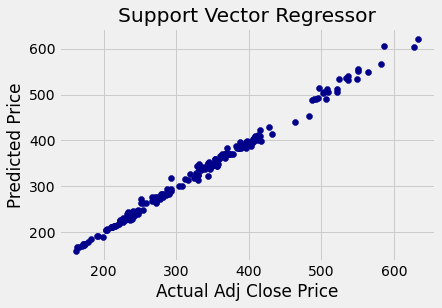

In [22]:
# data visualization

plt.scatter(df_svr.Adj_Close, df_svr.SVR_Predicted, color='Darkblue')
plt.title('Support Vector Regressor')
plt.xlabel("Actual Adj Close Price")
plt.ylabel("Predicted Price")
plt.show()

No handles with labels found to put in legend.


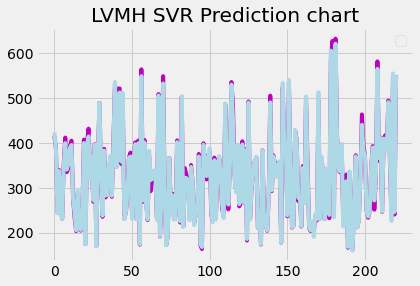

In [23]:
# data visualization 

plt.title("LVMH SVR Prediction chart")
plt.plot(df_svr.Adj_Close, color='m')
plt.plot(df_svr.SVR_Predicted, color='lightblue')
plt.legend()

## 2) Linear Regression

In [24]:
# create and train the Linear Regression Model
lr = LinearRegression()
# train the model
lr.fit(x_train, y_train)

LinearRegression()

In [25]:
# testing model: score returns the coefficient of determination R^2 of the prediction.
# the best possible score is 1.0
lr_confidence = lr.score(x_test, y_test)
print ("lr confidence:", lr_confidence)

lr confidence: 0.9961490701239754


In [26]:
# Model Evaluation 
lr_predicted = lr.predict(x_test)

In [27]:
lr_mae = metrics.mean_absolute_error(y_test, lr_predicted)
print ('Mean Absolute Error (MAE):', lr_mae)
lr_mse = metrics.mean_squared_error(y_test, lr_predicted)
print ('Mean Squared Error (MSE) :', lr_mse)
lr_rmse = np.sqrt(metrics.mean_squared_error(y_test, lr_predicted))
print ('Root Mean Squared Error (RMSE):', lr_rmse) 

Mean Absolute Error (MAE): 4.319618087385104
Mean Squared Error (MSE) : 40.1238037958336
Root Mean Squared Error (RMSE): 6.3343353081308855


In [28]:
# convert data set

df_lrr = pd.Series({'Mean Absolute Error' : lr_mae, 'Mean Square Error': lr_mse, 'Root Mean Squared Error': lr_rmse})
df_lrr = df_lrr.reset_index()
df_lrr = df_lrr.rename(columns = {0:'LR', 'index':'Eval'}, inplace=False)

In [29]:
df_lrr

,Eval,LR
0,Mean Absolute Error,4.319618
1,Mean Square Error,40.123804
2,Root Mean Squared Error,6.334335


In [30]:
df_lr = pd.DataFrame({'Adj_Close' : y_test, 'LR_Predicted' : lr_predicted})
df_lr

,Adj_Close,LR_Predicted
0,415.583221,421.882903
1,387.086121,387.309614
2,244.748245,245.056685
3,339.699341,331.833249
4,254.549515,246.429461
...,...,...
216,367.741669,368.613292
217,235.676529,224.949695
218,549.857727,550.832860
219,240.392105,245.766748


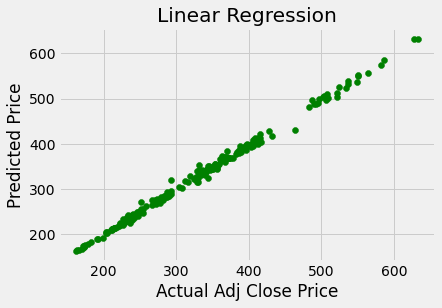

In [31]:
# data visualization

plt.scatter(df_lr.Adj_Close, df_lr.LR_Predicted, color='green')
plt.title('Linear Regression')
plt.xlabel("Actual Adj Close Price")
plt.ylabel("Predicted Price")
plt.show()

No handles with labels found to put in legend.


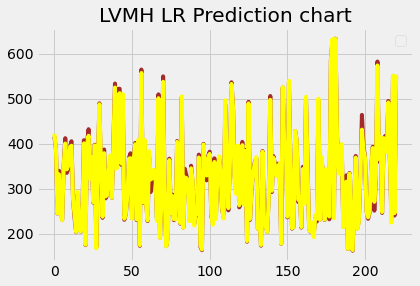

In [32]:
# data visualization 

plt.title("LVMH LR Prediction chart")
plt.plot(df_lr.Adj_Close, color='brown')
plt.plot(df_lr.LR_Predicted, color='yellow')
plt.legend()

## 3) Random Forest Regression 

In [33]:
# create and train the Random Forest Regression Model
reg = RandomForestRegressor(n_estimators=300, max_depth=300, random_state=42)
reg.fit(x_train, y_train)

RandomForestRegressor(max_depth=300, n_estimators=300, random_state=42)

In [34]:
# testing model: score returns the coefficient of determination R^2 of the prediction.
# the best possible score is 1.0
reg_confidence = reg.score(x_test, y_test)
print ("reg confidence:", reg_confidence)

reg confidence: 0.9943666092818776


In [35]:
# Model Evaluation 
reg_predicted = reg.predict(x_test)

In [36]:
reg_mae = metrics.mean_absolute_error(y_test, reg_predicted)
print ('Mean Absolute Error (MAE):', reg_mae)
reg_mse = metrics.mean_squared_error(y_test, reg_predicted)
print ('Mean Squared Error (MSE) :', reg_mse)
reg_rmse = np.sqrt(metrics.mean_squared_error(y_test, reg_predicted))
print ('Root Mean Squared Error (RMSE):', reg_rmse) 

Mean Absolute Error (MAE): 5.463347719613118
Mean Squared Error (MSE) : 58.69571016768248
Root Mean Squared Error (RMSE): 7.661312561675217


In [37]:
# convert data set

df_regg = pd.Series({'Mean Absolute Error' : reg_mae, 'Mean Square Error': reg_mse, 'Root Mean Squared Error': reg_rmse})
df_regg = df_regg.reset_index()
df_regg = df_regg.rename(columns = {0:'RF', 'index':'Eval'}, inplace=False)

In [38]:
df_regg

,Eval,RF
0,Mean Absolute Error,5.463348
1,Mean Square Error,58.695710
2,Root Mean Squared Error,7.661313


In [39]:
df_reg = pd.DataFrame({'Adj_Close' : y_test, 'RF_Predicted' : reg_predicted})
df_reg

,Adj_Close,RF_Predicted
0,415.583221,422.731589
1,387.086121,382.831807
2,244.748245,244.814320
3,339.699341,335.761422
4,254.549515,243.921673
...,...,...
216,367.741669,365.538244
217,235.676529,224.084915
218,549.857727,559.809172
219,240.392105,248.531789


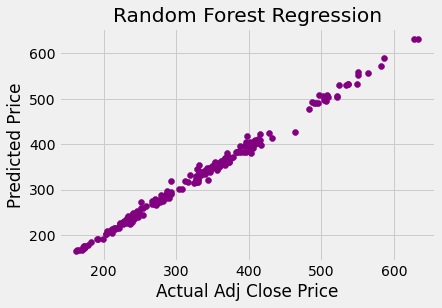

In [40]:
# data visualization

plt.scatter(df_reg.Adj_Close, df_reg.RF_Predicted, color='purple')
plt.title('Random Forest Regression')
plt.xlabel("Actual Adj Close Price")
plt.ylabel("Predicted Price")
plt.show()

No handles with labels found to put in legend.


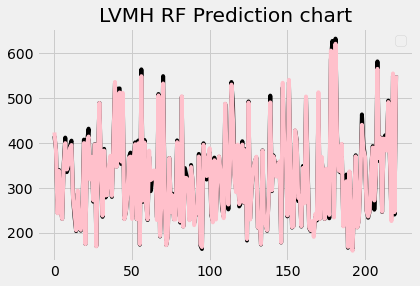

In [41]:
# data visualization 

plt.title("LVMH RF Prediction chart")
plt.plot(df_svr.Adj_Close, color='black')
plt.plot(df_svr.SVR_Predicted, color='pink')
plt.legend()

## 4) XGBoost

In [42]:
# create and train the XGBoost Model
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
# testing model: score returns the coefficient of determination R^2 of the prediction.
# the best possible score is 1.0
xgb_confidence = xgb.score(x_test, y_test)
print ("xgb confidence:", xgb_confidence)

xgb confidence: 0.9927036901808107


In [44]:
# Model Evaluation 
xgb_predicted = xgb.predict(x_test)

In [45]:
xgb_mae = metrics.mean_absolute_error(y_test, xgb_predicted)
print ('Mean Absolute Error (MAE):', xgb_mae)
xgb_mse = metrics.mean_squared_error(y_test, xgb_predicted)
print ('Mean Squared Error (MSE) :', xgb_mse)
xgb_rmse = np.sqrt(metrics.mean_squared_error(y_test, xgb_predicted))
print ('Root Mean Squared Error (RMSE):', xgb_rmse) 

Mean Absolute Error (MAE): 6.20512769880338
Mean Squared Error (MSE) : 76.0220811709454
Root Mean Squared Error (RMSE): 8.719064237115438


In [46]:
# convert data set 

df_xgbb = pd.Series({'Mean Absolute Error' : xgb_mae, 'Mean Square Error': xgb_mse, 'Root Mean Squared Error': xgb_rmse})
df_xgbb = df_xgbb.reset_index()
df_xgbb = df_xgbb.rename(columns = {0:'XGB', 'index':'Eval'}, inplace=False)

In [47]:
df_xgbb

,Eval,XGB
0,Mean Absolute Error,6.205128
1,Mean Square Error,76.022081
2,Root Mean Squared Error,8.719064


In [48]:
df_xgb = pd.DataFrame({'Adj_Close' : y_test, 'XGB_Predicted' : xgb_predicted})
df_xgb

,Adj_Close,XGB_Predicted
0,415.583221,423.415558
1,387.086121,382.086914
2,244.748245,243.007111
3,339.699341,338.236389
4,254.549515,241.692780
...,...,...
216,367.741669,367.524689
217,235.676529,223.574844
218,549.857727,560.579956
219,240.392105,246.048813


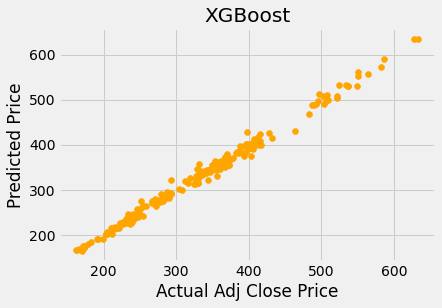

In [49]:
# data visualization

plt.scatter(df_xgb.Adj_Close, df_xgb.XGB_Predicted, color='orange')
plt.title('XGBoost')
plt.xlabel("Actual Adj Close Price")
plt.ylabel("Predicted Price")
plt.show()

No handles with labels found to put in legend.


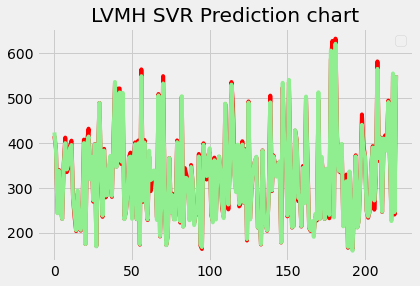

In [50]:
# data visualization 

plt.title("LVMH SVR Prediction chart")
plt.plot(df_svr.Adj_Close, color='red')
plt.plot(df_svr.SVR_Predicted, color='lightgreen')
plt.legend()

In [51]:
# choose the best model

df_final = pd.merge(df_svr, df_lr, 'inner', 'Adj_Close')
df_final = pd.merge(df_final, df_reg, 'inner', 'Adj_Close')
df_final = pd.merge(df_final, df_xgb, 'inner', 'Adj_Close')
df_final.head()

,Adj_Close,SVR_Predicted,LR_Predicted,RF_Predicted,XGB_Predicted
0,415.583221,423.679488,421.882903,422.731589,423.415558
1,387.086121,384.476244,387.309614,382.831807,382.086914
2,387.086121,384.476244,387.309614,382.831807,386.671936
3,387.086121,384.476244,387.309614,384.349685,382.086914
4,387.086121,384.476244,387.309614,384.349685,386.671936


In [52]:
df_eval = pd.merge(df_svrr, df_lrr, 'inner', 'Eval')
df_eval = pd.merge(df_eval, df_regg, 'inner', 'Eval')
df_eval = pd.merge(df_eval, df_xgbb, 'inner', 'Eval')
df_eval

,Eval,SVR,LR,RF,XGB
0,Mean Absolute Error,5.132023,4.319618,5.463348,6.205128
1,Mean Square Error,54.993671,40.123804,58.695710,76.022081
2,Root Mean Squared Error,7.415772,6.334335,7.661313,8.719064


# Summary
Above observation, Linear Regression model gives the best result which has the nearest score R^2 & RMSE amongst the machine learning models.

## The next day stock price prediction.

In [53]:
# set x_forecast equal to the last "n" row of the original data set form Adj Close column.
x_forecast = np.array(df.drop(['Prediction'], 1))[-forecast_out:]
x_forecast

array([[626.20001221]])

In [54]:
# print Support Vector Regressor model prediction for the next 'n' days
svr_prediction = svr_rbf.predict(x_forecast)
print ("svr prediction:", svr_prediction)

svr prediction: [629.51251731]


In [55]:
# print Linear Regression model prediction for the next 'n' days
lr_prediction = lr.predict(x_forecast)
print ("lr prediction:", lr_prediction)

lr prediction: [626.36032116]


In [56]:
# print Random Forest Regression model prediction for the next 'n' days
reg_prediction = reg.predict(x_forecast)
print ("reg prediction:", reg_prediction)

reg prediction: [625.76101685]


In [57]:
# print XGBoost model prediction for the next 'n' days
xgb_prediction = xgb.predict(x_forecast)
print ("xgb prediction:", xgb_prediction)

xgb prediction: [620.9164]
